In [299]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, fc1_unit=None, fc2_unit=None):
        super(NeuralNetwork, self).__init__()
        if fc1_unit is None:
            self.big = False
            self.fc1 = nn.Linear(input_size, 64)
            self.fc2 = nn.Linear(64, output_size)
        else:
            self.big = True
            self.fc1 = nn.Linear(input_size, fc1_unit)
            self.fc2 = nn.Linear(fc1_unit, fc2_unit)
            self.fc3 = nn.Linear(fc2_unit, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))

        if not self.big:
            x = self.fc2(x)
        else:
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
        return x



maze14x14 = { "starting_pos": [[0,0], [5,0], [7,0], [13,0], [13,5], [13,8], [13,11]],
             "maze":[
                    ['x', '#', 'x', 'x', '.', '.', '.', '.', '#', '#', '#', '#', '.', 'G'],#0
                    ['x', '#', 'x', '#', '#', '#', '.', '.', '.', 'x', 'x', 'x', '.', '.'],#1
                    ['x', 'x', 'x', 'x', '.', '#', '.', '.', '#', 'x', 'x', '#', '.', '.'],#2
                    ['x', '#', '#', '#', '.', '#', '.', '.', '.', 'x', 'x', '#', '.', '.'],#3
                    ['x', 'x', '#', 'x', '.', '#', '#', '#', '#', '#', '.', '#', '#', '.'],#4
                    ['x', 'x', 'x', 'x', '.', '.', '.', 'x', 'x', 'x', '.', '.', '#', '.'],#5
                    ['#', '#', '#', '#', '#', '.', '#', '#', 'x', 'x', '.', '.', '#', '.'],#6
                    ['.', '.', '.', '.', '#', '.', '.', '#', 'x', 'x', '.', '.', '.', '.'],#7
                    ['.', '.', '.', '.', '#', '.', '.', '#', '.', '#', '.', '#', '#', '#'],#8
                    ['#', '.', '#', '.', '#', '.', '#', '#', '.', '#', '.', '.', '.', '.'],#9
                    ['.', '.', '#', '.', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.'],#10
                    ['.', '#', '#', 'x', '#', '.', '.', '.', '.', '#', '.', '#', '#', '.'],#11
                    ['.', 'x', 'x', 'x', '#', '#', '.', '#', '.', '#', '.', '.', '#', '.'],#12
                    ['S', 'x', '#', 'x', '#', '.', '.', '#', '.', '#', '.', '.', '#', '.'],#13
                    # 0    1    2    3    4    5    6    7    8    9   10   11   12   13
                    ]
            }

def probMapper(grid, shape, n_models):

    print("Loading models...")
    grid_models = []

    for i in range(n_models):
        if shape == "5x5":
            model = NeuralNetwork(3, 2)
        elif shape == "14x14":
            model = NeuralNetwork(3, 2, 128, 64)

        model.load_state_dict(torch.load("../data/offline_models/{}_{}.pt".format(shape, i)))
        model.eval()

        grid_models.append(model)
    
    print("Models loaded")


    empty_grid = [['' for i in range(len(grid[0]))] for j in range(len(grid))]

    for y in range(len(grid)):
        for x in range(len(grid[y])):
            if grid[y][x] == "#":
                empty_grid[y][x] = "#" 
            else:
                for i in range(4):
                    posibilidades = []

                    test_input = torch.tensor([[float(y), float(x), float(i)]], dtype=torch.float32)
                    
                    for i in range(len(grid_models)):
                        resultado = grid_models[i](test_input)
                        resultado = resultado.detach().numpy()
                        posibilidades.append([round(resultado[0][0]), round(resultado[0][1])])
                    
                    #Calculo el porcentaje de veces que aparece cada posibilidad
                    probability_dict = {str(posibilidades.count(p)/len(posibilidades)*100) + "%": p for p in posibilidades}

                    probability_dict = {}
                    for p in posibilidades:
                        if not str(p) in probability_dict:
                            probability_dict[str(p)] = str(posibilidades.count(p)/len(posibilidades))

                    #Ordeno el diccionario por las probabilidades de mayor a menor
                    probability_dict = {k: v for k, v in sorted(probability_dict.items(), key=lambda item: item[1], reverse=True)}
                    
                    highest_probability = list(probability_dict.keys())[0]

                    #convertirla de nuevo a lista
                    highest_probability = highest_probability.replace("[", "").replace("]", "").split(", ")

                    highest_probability = [highest_probability[0], highest_probability[1]]

                    for p in probability_dict:
                        empty_grid[y][x] = empty_grid[y][x] + str(p) + ": "+ str(round(float(probability_dict[p])*100, 2))+"% "
                        break
                    #print("Probabilidad " + str(p) + ": " + str(posibilidades.count(p)/len(posibilidades)*100) + "%")


    #now I want to plot the grid, each cell containing their string

    binary_grid = np.where(np.array(empty_grid) == '#', 0, 1)
    
    plt.figure(figsize=(16, 16))

    # Create a plot
    plt.imshow(binary_grid, cmap='gray', interpolation='nearest')
    # Set the locations of gridlines explicitly to have them at non
    # -even indices
    plt.xticks(np.arange(-0.5, len(binary_grid[0]), 1), [])
    plt.yticks(np.arange(-0.5, len(binary_grid), 1), [])

    plt.grid(True, color='black', linewidth=2, which='both', linestyle='-', alpha=0.5)

    # Draw diagonal lines in each cell to divide it into sectors
    for i in range(len(binary_grid)):
        for j in range(len(binary_grid[0])):

            if binary_grid[i, j] == 1:  # Check if the cell is white
                plt.plot([j - 0.5, j + 0.5], [i - 0.5, i + 0.5], color='black', linewidth=1)
                plt.plot([j + 0.5, j - 0.5], [i - 0.5, i + 0.5], color='black', linewidth=1)

                text = empty_grid[i][j].split("%")
                text1state = text[0].split(":")[0].replace(" ", "")
                text1prob = text[0].split(":")[1] + "%"
                text2state = text[1].split(":")[0].replace(" ", "")
                text2prob = text[1].split(":")[1] + "%"
                text3state = text[2].split(":")[0].replace(" ", "")
                text3prob = text[2].split(":")[1] + "%"
                text4state = text[3].split(":")[0].replace(" ", "")
                text4prob = text[3].split(":")[1] + "%"


                # Add text based on the sector
                if float(text[0].split(":")[1]) > 50.0:
                    color1 = 'green'
                elif float(text[0].split(":")[1]) < 35.0:
                    color1 = 'red'
                else:
                    color1 = 'black'
                if float(text[1].split(":")[1]) > 50.0:
                    color2 = 'green'
                elif float(text[1].split(":")[1]) < 35.0:
                    color2 = 'red'
                else:
                    color2 = 'black'
                if float(text[2].split(":")[1]) > 50.0:
                    color3 = 'green'
                elif float(text[2].split(":")[1]) < 35.0:
                    color3 = 'red'
                else:
                    color3 = 'black'
                if float(text[3].split(":")[1]) > 50.0:
                    color4 = 'green'
                elif float(text[3].split(":")[1]) < 35.0:
                    color4 = 'red'
                else:
                    color4 = 'black'

                plt.text(j, i - .4, text1state, ha='center', va='center', fontsize=6, color=color1)  # North
                plt.text(j, i - .25, text1prob, ha='center', va='center', fontsize=6, color=color1)  # North

                plt.text(j, i + .25, text2prob, ha='center', va='center', fontsize=6, color=color2)  # South
                plt.text(j, i + .4, text2state, ha='center', va='center', fontsize=6, color=color2)  # South

                plt.text(j - .3, i - .1, text3state, ha='center', va='center', fontsize=6, color=color3)  # West
                plt.text(j - .3, i + .05, text3prob, ha='center', va='center', fontsize=6, color=color3)  # West

                plt.text(j + .3, i - .1, text4state, ha='center', va='center', fontsize=6, color=color4)  # East
                plt.text(j + .3, i + .05, text4prob, ha='center', va='center', fontsize=6, color=color4)  # East


    #  Add row numbering on the left from top to bottom
    for i, label in enumerate(range(len(binary_grid))):
        plt.text(-0.8, i, str(label), ha='right', va='center', fontsize=12, color='black')

    # Add column numbering at the bottom
    for j, label in enumerate(range(len(binary_grid[0]))):
        plt.text(j, len(binary_grid) - 0.3, str(label), ha='center', va='top', fontsize=12, color='black')

    # Show the plot
    plt.show()



            

Loading models...
Models loaded


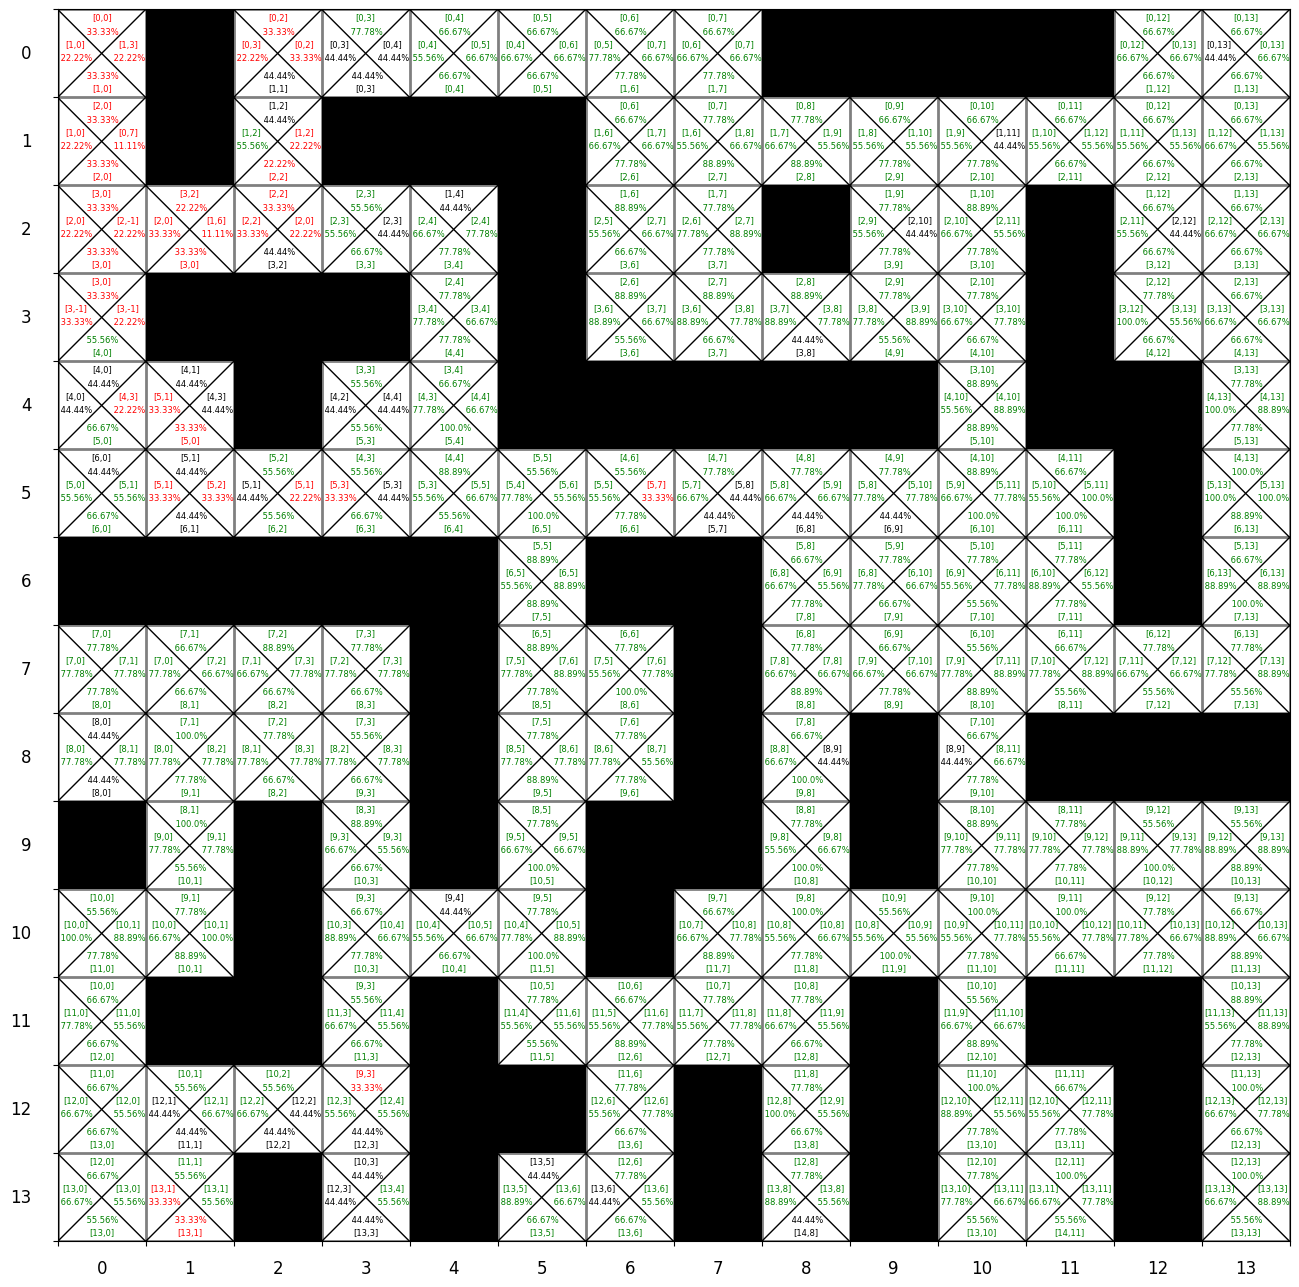

In [300]:
maze = maze14x14["maze"]

probMapper(maze, "14x14", 9)

In [252]:
import random

In [253]:
def transition_generator(maze, with_walls = True):
    transiciones = []

    n_rows, n_cols = len(maze), len(maze[0])

    for y in range(n_rows):
        for x in range(n_cols):
            # Si la casilla actual es un muro o una casilla 'x' (forzada a no demostracion),
            # no se puede guardar la transición
            if maze[y][x] != '#' and maze[y][x] != 'x':
                for a in range(4):
                    if a == 0:  # Mover hacia el norte
                        y1, x1 = max(0, y - 1), x
                    elif a == 1:  # Mover hacia el sur
                        y1, x1 = min(n_rows - 1, y + 1), x
                    elif a == 2:  # Mover hacia el oeste
                        y1, x1 = y, max(0, x - 1)
                    elif a == 3:  # Mover hacia el este
                        y1, x1 = y, min(n_cols - 1, x + 1)

                    # Si la casilla siguiente es un muro y el booleano es válido,
                    # se debe guardar la transición de la casilla actual a sí misma
                    if maze[y1][x1] == '#':
                        if with_walls:
                            transiciones.append([y, x, a, y, x])
                    # Si la casilla siguiente es una casilla 'x' no vamos a guardar ninguna transición
                    elif maze[y1][x1] == 'x':
                        pass
                    # Si la siguiente no es ninguna de las anteriores, se guarda la transición
                    else:
                        transiciones.append([y, x, a, y1, x1])

    return transiciones

In [254]:
def transitions_families_generator_66(transiciones_iniciales, n):
    n_transiciones_iniciales = len(transiciones_iniciales)
    n_borradas = int((1 - 0.66) * n_transiciones_iniciales)

    nuevos_arrays = []

    for _ in range(n):
        # Crear una copia de las transiciones iniciales
        nuevas_transiciones = transiciones_iniciales.copy()

        # Eliminar aleatoriamente 'n_retenidas' sublistas
        transiciones_a_eliminar = random.sample(nuevas_transiciones, n_borradas)
        for t in transiciones_a_eliminar:
            nuevas_transiciones.remove(t)

        # Repetir aleatoriamente 'n_borradas' transiciones
        transiciones_a_repetir = random.sample(nuevas_transiciones, n_borradas)
        nuevas_transiciones.extend(transiciones_a_repetir)

        nuevos_arrays.append(nuevas_transiciones)

    return nuevos_arrays

In [255]:
from collections import defaultdict

def count_original_transitions(all_transitions, new_transitions):
    # Aplanar la lista de sublistas
    flattened_new_transitions = [item for sublist in new_transitions for item in sublist]

    # Inicializar un diccionario para contar las transiciones originales
    counts = defaultdict(int)

    # Contar la frecuencia de cada transición original
    for transition in flattened_new_transitions:
        counts[tuple(transition)] += 1

    index = 1
    # Imprimir los resultados
    for original_transition in all_transitions:
        count = counts.get(tuple(original_transition), 0)
        print(f"{index} Transición: {original_transition}, Apariciones: {count}")
        index += 1

In [256]:
def transitions_families_generator_FULLY_REPRESENTED(transiciones_iniciales, n):
    n_transiciones_iniciales = len(transiciones_iniciales)
    n_subset = int(0.66 * n_transiciones_iniciales)

    nuevos_arrays = []

    for i in range(n):

        # Crear una copia de las transiciones iniciales
        nuevas_transiciones = transiciones_iniciales.copy()
        
        start_index = (i * n_subset) % len(nuevas_transiciones)
        end_index = (start_index + n_subset) % len(nuevas_transiciones)

        if start_index < end_index:
            nuevas_transiciones = nuevas_transiciones[start_index:end_index]
        else:
            nuevas_transiciones = nuevas_transiciones[start_index:] + nuevas_transiciones[:end_index]        

        # Repetir aleatoriamente 'n_borradas' transiciones
        transiciones_a_repetir = random.sample(nuevas_transiciones, n_transiciones_iniciales - n_subset)
        nuevas_transiciones.extend(transiciones_a_repetir)

        nuevos_arrays.append(nuevas_transiciones)

    return nuevos_arrays

In [257]:
maze5x5 = { "starting_pos": [[0,0], [2,0], [4,0]],
             "maze":[
                    ['.', '.', '#', '.', 'G'],#0            0
                    ['.', '.', '#', '.', '.'],#1            ↑
                    ['.', '.', '.', '.', '.'],#2         2 ← → 3
                    ['.', '.', '#', '.', '.'],#3            ↓
                    ['S', '.', '#', '.', '.'],#4            1
                    # 0    1    2    3    4
                    ]
        }

maze14x14 = { "starting_pos": [[0,0], [5,0], [7,0], [13,0], [13,5], [13,8], [13,11]],
             "maze":[
                    ['.', '#', '.', '.', '.', '.', '.', '.', '#', '#', '#', '#', '.', 'G'],#0
                    ['.', '#', '.', '#', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.'],#1
                    ['.', '.', '.', '.', '.', '#', '.', '.', '#', '.', '.', '#', '.', '.'],#2
                    ['.', '#', '#', '#', '.', '#', '.', '.', '.', '.', '.', '#', '.', '.'],#3
                    ['.', '.', '#', '.', '.', '#', '#', '#', '#', '#', '.', '#', '#', '.'],#4
                    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '#', '.'],#5
                    ['#', '#', '#', '#', '#', '.', '#', '#', '.', '.', '.', '.', '#', '.'],#6
                    ['.', '.', '.', '.', '#', '.', '.', '#', '.', '.', '.', '.', '.', '.'],#7
                    ['.', '.', '.', '.', '#', '.', '.', '#', '.', '#', '.', '#', '#', '#'],#8
                    ['#', '.', '#', '.', '#', '.', '#', '#', '.', '#', '.', '.', '.', '.'],#9
                    ['.', '.', '#', '.', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.'],#10
                    ['.', '#', '#', '.', '#', '.', '.', '.', '.', '#', '.', '#', '#', '.'],#11
                    ['.', '.', '.', '.', '#', '#', '.', '#', '.', '#', '.', '.', '#', '.'],#12
                    ['S', '.', '#', '.', '#', '.', '.', '#', '.', '#', '.', '.', '#', '.'],#13
                    # 0    1    2    3    4    5    6    7    8    9   10   11   12   13
                    ]
            }

In [258]:
maze = maze14x14["maze"]

In [259]:
all_transitions = transition_generator(maze)

print("Número de transiciones generadas:", len(all_transitions))
n = 2  # Generar N nuevos arrays

Número de transiciones generadas: 520


In [260]:
new_transitions = transitions_families_generator_FULLY_REPRESENTED(all_transitions, n)

In [261]:
print(len(all_transitions))

"""for t in all_transitions:
    print(t)"""

count_original_transitions(all_transitions, new_transitions)

520
1 Transición: [0, 0, 0, 0, 0], Apariciones: 3
2 Transición: [0, 0, 1, 1, 0], Apariciones: 4
3 Transición: [0, 0, 2, 0, 0], Apariciones: 2
4 Transición: [0, 0, 3, 0, 0], Apariciones: 2
5 Transición: [0, 2, 0, 0, 2], Apariciones: 2
6 Transición: [0, 2, 1, 1, 2], Apariciones: 4
7 Transición: [0, 2, 2, 0, 2], Apariciones: 3
8 Transición: [0, 2, 3, 0, 3], Apariciones: 2
9 Transición: [0, 3, 0, 0, 3], Apariciones: 3
10 Transición: [0, 3, 1, 0, 3], Apariciones: 2
11 Transición: [0, 3, 2, 0, 2], Apariciones: 2
12 Transición: [0, 3, 3, 0, 4], Apariciones: 3
13 Transición: [0, 4, 0, 0, 4], Apariciones: 3
14 Transición: [0, 4, 1, 0, 4], Apariciones: 2
15 Transición: [0, 4, 2, 0, 3], Apariciones: 3
16 Transición: [0, 4, 3, 0, 5], Apariciones: 3
17 Transición: [0, 5, 0, 0, 5], Apariciones: 4
18 Transición: [0, 5, 1, 0, 5], Apariciones: 2
19 Transición: [0, 5, 2, 0, 4], Apariciones: 2
20 Transición: [0, 5, 3, 0, 6], Apariciones: 3
21 Transición: [0, 6, 0, 0, 6], Apariciones: 2
22 Transición: [0,